In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel('data.xlsx')
df

,price,hang,dong,namdangki,soKM,tinhTrang,loaiXe,dungTich,chinhSachBH
0,68686868,Honda,SH,2022,8000,Đã sử dụng,Tay ga,100 - 175 cc,Bảo hành hãng
1,68686868,Honda,SH,2022,1000,Đã sử dụng,Tay ga,100 - 175 cc,Bảo hành hãng
2,62999999,Honda,SH,2018,8900,Đã sử dụng,Tay ga,100 - 175 cc,Bảo hành hãng
3,6800000,Honda,Lead,2012,16800,Đã sử dụng,Tay ga,100 - 175 cc,Bảo hành hãng
4,15600000,Honda,Air Blade,2016,18600,Đã sử dụng,Tay ga,100 - 175 cc,Bảo hành hãng
...,...,...,...,...,...,...,...,...,...
3267,11500000,Piaggio,Vespa S125,2013,2600,Đã sử dụng,Tay ga,100 - 175 cc,Bảo hành hãng
3268,35000000,Honda,CBR,2023,1199,Đã sử dụng,Tay côn/Moto,100 - 175 cc,Bảo hành hãng
3269,38000000,Kawasaki,W175,2019,4000,Đã sử dụng,Tay côn/Moto,Trên 175 cc,Bảo hành hãng
3270,8800000,Honda,Wave,2019,3600,Đã sử dụng,Xe số,100 - 175 cc,Bảo hành hãng


In [3]:
from sklearn.model_selection import train_test_split

# split the dataset into training and test set
train, test = train_test_split(df, test_size=0.2, random_state=122)

# check the dimension of the training and test dataset
print('Training dataset: ', train.shape)
print('Test dataset: ', test.shape)


Training dataset:  (2617, 9)
Test dataset:  (655, 9)


In [8]:
# segregate the feature matrix and target vector
Xtrain = train.drop(columns=['price'], axis=1)
ytrain = train['price']

Xtest = test.drop(columns=['price'], axis=1)
ytest = test['price']

In [9]:
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# categorical columns
categorical_features = ['hang', 'dong', 'tinhTrang', 'loaiXe', 'dungTich', 'chinhSachBH']

# numeric columns
numeric_features = ['namdangki', 'soKM']

# create transformers
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Handle unknown categories
])

numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=2))
])

# create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ])

# create the final pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('scaler', MaxAbsScaler())])


In [10]:
# perform feature transformation to train and test dataset
Xtrain_processed = pipeline.fit_transform(Xtrain)
Xtest_processed = pipeline.transform(Xtest)


In [11]:
# transform the 'Price' value into log scale
ytrain_log = np.log(ytrain)
ytest_log = np.log(ytest)

In [12]:
from sklearn.impute import SimpleImputer

# Chuyển đổi ytrain_log thành 2D array
ytrain_log_2d = np.array(ytrain_log).reshape(-1, 1)
# Khởi tạo SimpleImputer với strategy là 'mean' để điền giá trị trung bình
imputer = SimpleImputer(strategy='mean')

# Sử dụng imputer để điền giá trị NaN trong Xtrain_processed
Xtrain_processed_imputed = imputer.fit_transform(Xtrain_processed)
ytrain_log_imputed = imputer.fit_transform(ytrain_log_2d)


### Model 1: Decision Tree

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

# create a Decision Tree Regressor
tree = DecisionTreeRegressor()

# define the hyperparameter grid to search
param_grid = {
    'max_depth': [10, 20, 30],              # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],        # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]           # Minimum number of samples required to be at a leaf node
}

# create the GridSearchCV object
grid_search_tree = GridSearchCV(estimator=tree, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# fit the model to the training data
grid_search_tree.fit(Xtrain_processed_imputed, ytrain_log_imputed)

# get the best hyperparameters
best_params = grid_search_tree.best_params_
print("Best Hyperparameters:", best_params)

# get the best model
best_tree = grid_search_tree.best_estimator_

Best Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10}


### Model 2: Random Forest

In [10]:
from sklearn.ensemble import RandomForestRegressor

# create a Random Forest Regressor
forest = RandomForestRegressor()

# define the hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],        # Number of trees in the forest
    'max_depth': [10, 20, 30],              # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],        # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]           # Minimum number of samples required to be at a leaf node
}

# create the GridSearchCV object
grid_search_forest = GridSearchCV(estimator=forest, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# fit the model to the training data
grid_search_forest.fit(Xtrain_processed_imputed, ytrain_log_imputed)

# get the best hyperparameters
best_params = grid_search_forest.best_params_
print("Best Hyperparameters:", best_params)

# get the best model
best_forest = grid_search_forest.best_estimator_

Best Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


### Model 3: KNN Regressor

In [11]:
from sklearn.neighbors import KNeighborsRegressor

# create a KNN Regressor
knn = KNeighborsRegressor(n_neighbors=2)

# define the hyperparameter grid to search
param_grid = {
    'n_neighbors': [2,4,6,8,10]
}

# create the GridSearchCV object
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# fit the model to the training data
grid_search_knn.fit(Xtrain_processed_imputed, ytrain_log_imputed)

# get the best hyperparameters
best_params = grid_search_knn.best_params_
print("Best Hyperparameters:", best_params)

# get the best model
best_knn = grid_search_knn.best_estimator_

Best Hyperparameters: {'n_neighbors': 6}


### Model 4: Ridge Regression

In [12]:
from sklearn.linear_model import Ridge

# create Ridge Regression model
ridge = Ridge()

# define the hyperparameter grid for Ridge Regression
ridge_param_grid = {
    'alpha': [0.1, 1, 10, 100]  # Regularization strength
}

# create the GridSearchCV object for Ridge Regression
ridge_grid_search = GridSearchCV(estimator=ridge, param_grid=ridge_param_grid, scoring='neg_mean_squared_error', cv=5)

# fit the Ridge model to the training data
ridge_grid_search.fit(Xtrain_processed_imputed, ytrain_log_imputed)

# get the best hyperparameters for Ridge Regression
best_ridge_params = ridge_grid_search.best_params_
print("Best Ridge Hyperparameters:", best_ridge_params)

# get the best Ridge model
best_ridge = ridge_grid_search.best_estimator_

Best Ridge Hyperparameters: {'alpha': 0.1}


### Model 5: Lasso Regression

In [13]:
from sklearn.linear_model import Lasso

# create Lasso Regression model
lasso = Lasso()

# define the hyperparameter grid for Lasso Regression
lasso_param_grid = {
    'alpha': [0.1, 1, 10, 100]  # Regularization strength
}

# create the GridSearchCV object for Lasso Regression
lasso_grid_search = GridSearchCV(estimator=lasso, param_grid=lasso_param_grid, scoring='neg_mean_squared_error', cv=5)

# fit the Lasso model to the training data
lasso_grid_search.fit(Xtrain_processed_imputed, ytrain_log_imputed)

# get the best hyperparameters for Lasso Regression
best_lasso_params = lasso_grid_search.best_params_
print("Best Lasso Hyperparameters:", best_lasso_params)

# get the best Lasso model
best_lasso = lasso_grid_search.best_estimator_

Best Lasso Hyperparameters: {'alpha': 0.1}


In [14]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def model_eval(X,y,clf,tag):
    ypred = clf.predict(X)
    
    r2 = r2_score(y, ypred)
    mse = mean_squared_error(y, ypred)
    rmse = mean_squared_error(y, ypred, squared=False)
    mae = mean_absolute_error(y, ypred)
    
    metrics = [r2, mse, rmse, mae]
    metricsName = ['R-Square', 'MSE', 'RMSE', 'MAE']
    
    res = pd.DataFrame(metrics, columns=[tag], index=metricsName)
    
    return res

In [15]:
tree_res = model_eval(Xtrain_processed_imputed, ytrain_log_imputed, best_tree, 'Decision Tree')
forest_res = model_eval(Xtrain_processed_imputed, ytrain_log_imputed, best_forest, 'Random Forest')
knn_res = model_eval(Xtrain_processed_imputed, ytrain_log_imputed, best_knn, 'KNearestNeighbors')
ridge_res = model_eval(Xtrain_processed_imputed, ytrain_log_imputed, best_ridge, 'Ridge Regression')
lasso_res = model_eval(Xtrain_processed_imputed, ytrain_log_imputed, best_lasso, 'LASSO Regression')

# display the performance metrics for all models
models_performance = pd.concat([tree_res,forest_res,knn_res,ridge_res,lasso_res], axis=1)

display(models_performance)

,Decision Tree,Random Forest,KNearestNeighbors,Ridge Regression,LASSO Regression
R-Square,0.885143,0.884143,0.809268,0.693951,0.026294
MSE,0.080195,0.080893,0.133172,0.213688,0.679857
RMSE,0.283187,0.284418,0.364928,0.462264,0.824535
MAE,0.169314,0.183404,0.237816,0.333550,0.637735


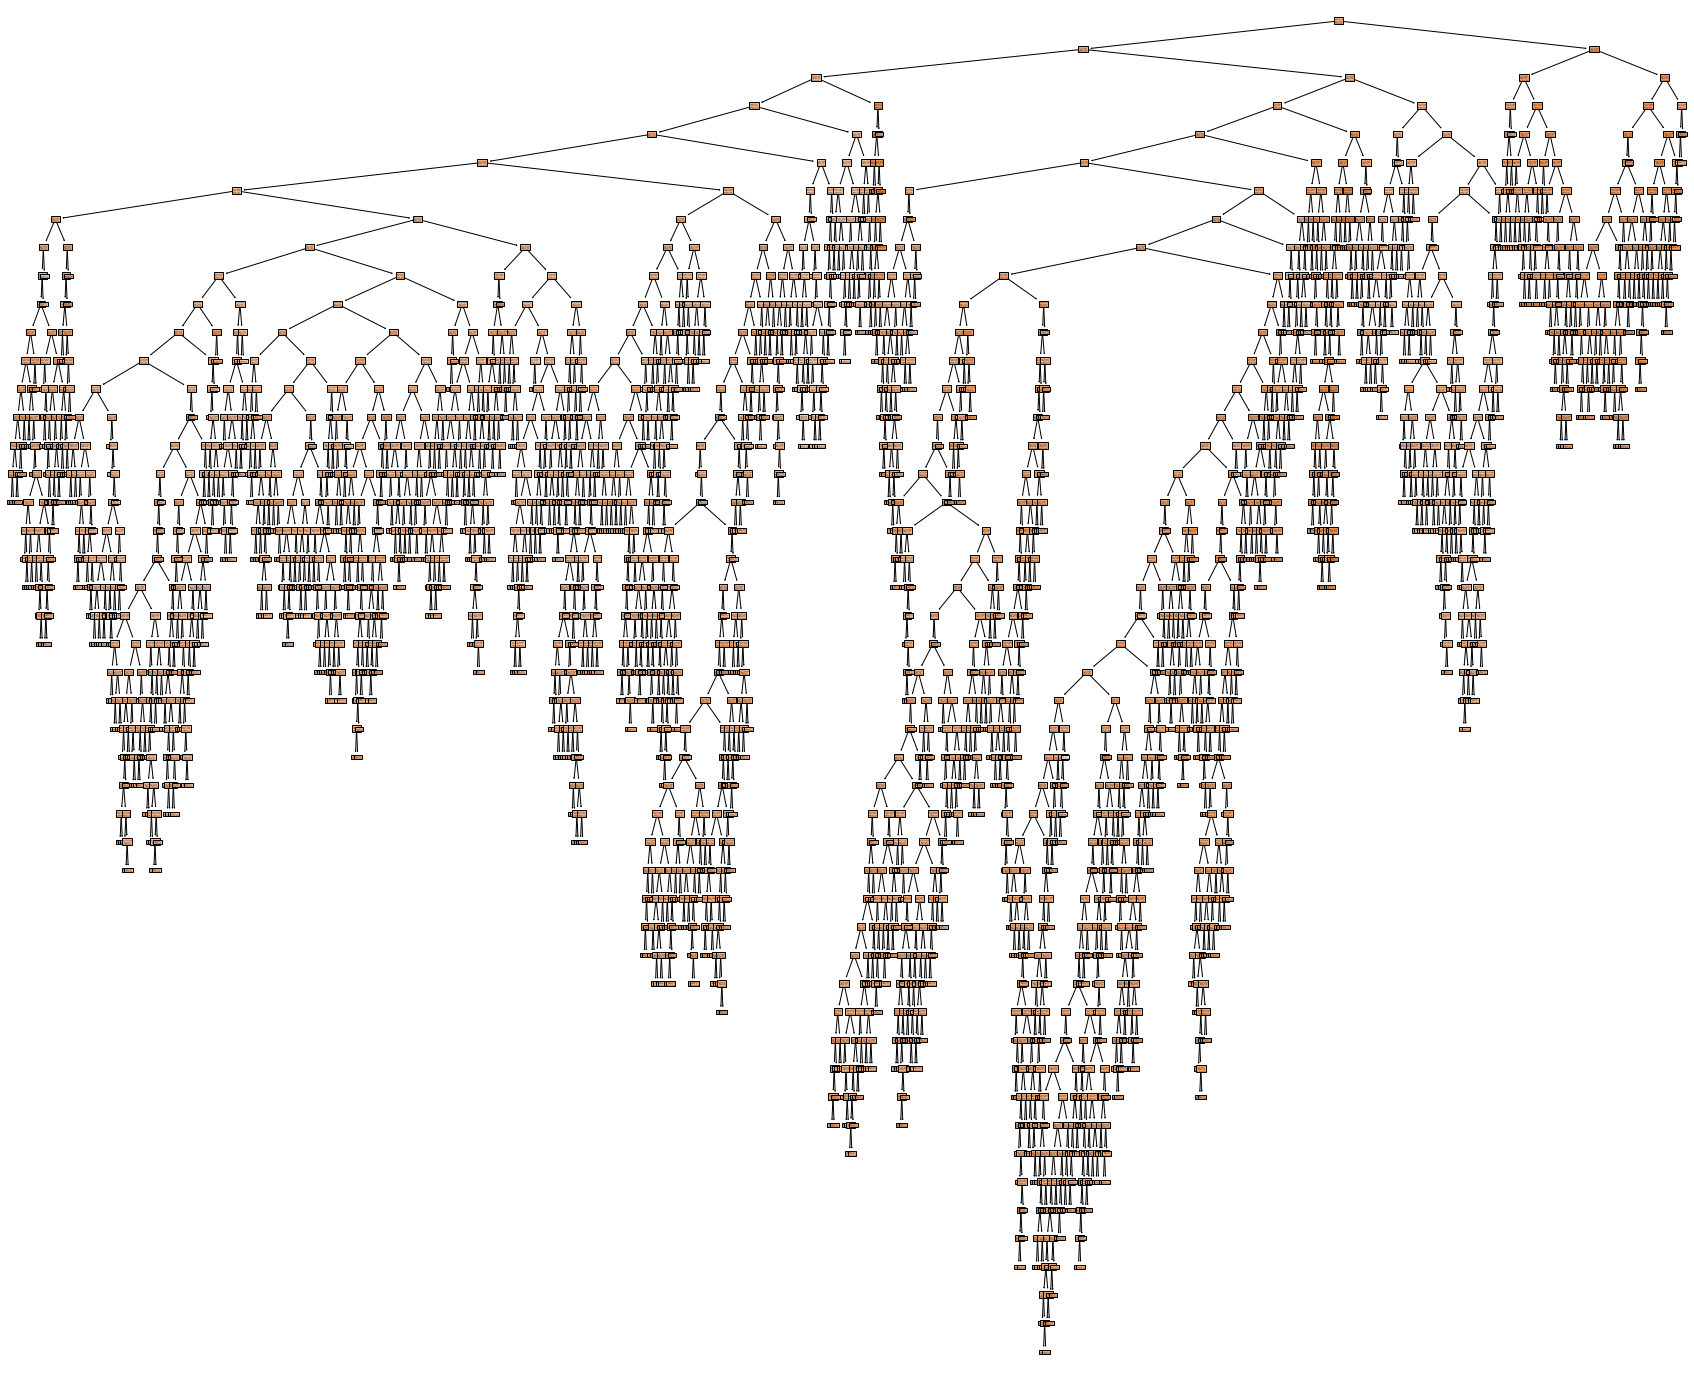

In [22]:

from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt



# Train a decision tree regressor
regressor = DecisionTreeRegressor()
regressor.fit(Xtrain_processed_imputed, ytrain_log_imputed)

# Plot the decision tree
plt.figure(figsize=(30, 25))
plot_tree(regressor, filled=True)
plt.show()


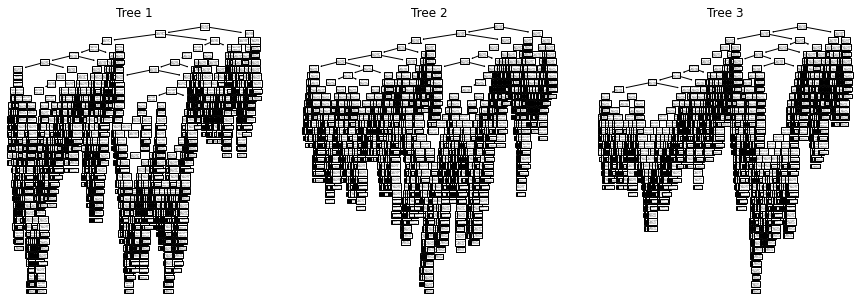

In [14]:
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import tree

# Load the Boston housing dataset (you can replace it with your own dataset)
boston = load_boston()
X = boston.data
y = boston.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Xtrain_processed_imputed, ytrain_log_imputed, test_size=0.2, random_state=42)

# Train a Random Forest regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(Xtrain_processed_imputed, ytrain_log_imputed)

# Visualize each tree in the forest
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for index in range(3):  # Visualize 3 trees
    tree.plot_tree(rf_regressor.estimators_[index], ax=axes[index])
    axes[index].set_title(f'Tree {index+1}')

plt.show()
